In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
from vae import VAE, loss_function
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import NumpyDataset, TQDMDaskProgressBar, load_npzs

In [13]:
env_name='sonic'
cuda=True
num_epochs=20
batch_size=6
data_cache_file = '/tmp/sonic_vae2.hdf5'

# Load data

In [14]:
# load as dask array

filenames = sorted(glob.glob('./data/vae/obs_data_' + env_name + '_*.npz'))

if not os.path.isfile(data_cache_file):
    data_train = load_npzs(filenames)
    print(data_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/x', data_train)
       
    # clear mem
    del data_train 
    import gc
    gc.collect()

In [15]:
# load
data = da.from_array(h5py.File(data_cache_file, mode='r')['x'], chunks=(600, 128, 128, 3))
data
data_split = int(len(data)*0.8)
data_train = data[:data_split]
data_test = data[data_split:]
data_train, data_test

(dask.array<getitem, shape=(96000, 128, 128, 3), dtype=float32, chunksize=(600, 128, 128, 3)>,
 dask.array<getitem, shape=(24000, 128, 128, 3), dtype=float32, chunksize=(600, 128, 128, 3)>)

In [16]:
import torch.utils.data

class NumpyDataset(torch.utils.data.Dataset):
    """Dataset wrapping arrays.

    Each sample will be retrieved by indexing array along the first dimension.

    Arguments:
        *arrays (numpy.array): arrays that have the same size of the first dimension.
    """

    def __init__(self, *arrays):
        assert all(arrays[0].shape[0] == array.shape[0] for array in arrays)
        self.arrays = arrays

    def __getitem__(self, index):
        return tuple(array[index].compute() for array in self.arrays)

    def __len__(self):
        return self.arrays[0].shape[0]
    
dataset_train = NumpyDataset(data_train)
loader_train = torch.utils.data.DataLoader(dataset_train, pin_memory=True, shuffle=False, batch_size=batch_size)


dataset_test = NumpyDataset(data_test)
loader_test = torch.utils.data.DataLoader(dataset_test, pin_memory=True, shuffle=False, batch_size=batch_size)

dataset_train, loader_train

(<__main__.NumpyDataset at 0x7f12c1a3ff60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f12c1a3ff98>)

# Model

In [17]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
import torch.nn as nn


class ConvBlock(torch.nn.Module):
    def __init__(self, inpt_kernel, output_kernel, kernel_size=4, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=inpt_kernel, out_channels=output_kernel, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(output_kernel)
        self.act = nn.ReLU(inplace=True)

        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_uniform(self.conv.weight, gain=gain)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class DeconvBlock(torch.nn.Module):
    def __init__(self, inpt_kernel, output_kernel, kernel_size=4, stride=2):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=inpt_kernel, out_channels=output_kernel, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(output_kernel)
        self.act = nn.ReLU(inplace=True)

        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_uniform(self.deconv.weight, gain=gain)

    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


# Reconstruction + KL divergence losses summed over all elements and batch
# https://github.com/pytorch/examples/blob/master/vae/main.py
def loss_function(recon_x, x, mu, logvar):
    n, c, h, w = recon_x.size()
    recon_x = recon_x.view(n, -1)
    x = x.view(n, -1)
    # L2 distance
    l2_dist = torch.mean(torch.sqrt(torch.sum(torch.pow(recon_x - x, 2), 1)))
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return l2_dist + KLD


n = 2  # multiplier to multiply input dims

class VAE(nn.Module):
    def __init__(self, latent_vector_dim=32 * n):
        super(VAE, self).__init__()
        # encoder part

        self.conv1 = ConvBlock(3, 32 * n, 4 * n, 2 * n)
        self.conv2 = ConvBlock(32 * n, 64 * n, 4, 2)
        self.conv3 = ConvBlock(64 * n, 128 * n, 4, 2)
        self.conv4 = ConvBlock(128 * n, 256 * n, 4, 2)

        self.mu = nn.Linear(1024 * n, latent_vector_dim)
        self.logvar = nn.Linear(1024 * n, latent_vector_dim)

        self.z = nn.Linear(latent_vector_dim, 1024 * n)

        # decoder part
        self.deconv1 = DeconvBlock(1024 * n, 128 * n, 5, 2)
        self.deconv2 = DeconvBlock(128 * n, 64 * n, 5, 2)
        self.deconv3 = DeconvBlock(64 * n, 32 * n, 6, 2)
        self.deconv4 = DeconvBlock(32 * n, 3, 6 * n, 2 * n)

        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        """
            Returns mean and log variance
        """
        x = self.conv4(self.conv3(self.conv2(self.conv1(x))))
        x = x.view(x.size()[0], -1)
        return self.mu(x), self.logvar(x)

    def sample(self, mu, logvar):
        if self.training:
            std = logvar.exp()
            std = std * Variable(std.data.new(std.size()).normal_())
            return mu + std
        else:
            return mu

    def decode(self, z):
        z = self.z(z)
        n, d = z.size()
        z = z.view(n, d, 1, 1)
        reconstruction = self.deconv4(self.deconv3(self.deconv2(self.deconv1(z))))
        reconstruction = self.sigmoid(reconstruction)
        return reconstruction

    def forward(self, x):
        """
            Returns reconstructed image, mean, and log variance
        """
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        x = self.decode(z)
        return x, mu, logvar


# View model

In [19]:
# Train
vae = VAE()
if cuda:
    vae.cuda()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [20]:
img = np.random.randn(64, 64, 3)
img = np.random.randn(64*2, 64*2, 3)
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()

with TorchSummarizeDf(vae) as tdf:
    x, mu, logvar = vae.forward(gpu_img)
    print(x.size())
    print(loss_function(x, gpu_img, mu, logvar))
    x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
    df = tdf.make_df()
df

torch.Size([1, 3, 128, 128])
tensor(247.9884, device='cuda:0')
Total parameters tensor(1.7413e+07)


,name,class_name,input_shape,output_shape,nb_params,level
1,conv1.conv,Conv2d,"[[(-1, 3, 128, 128)]]","[[(-1, 64, 31, 31)]]",tensor(12352),1
2,conv1.bn,BatchNorm2d,"[[(-1, 64, 31, 31)]]","[[(-1, 64, 31, 31)]]",tensor(128),1
3,conv1.act,ReLU,"[[(-1, 64, 31, 31)]]","[[(-1, 64, 31, 31)]]",0,1
4,conv1,ConvBlock,"[[(-1, 3, 128, 128)]]","[[(-1, 64, 31, 31)]]",tensor(12480),0
5,conv2.conv,Conv2d,"[[(-1, 64, 31, 31)]]","[[(-1, 128, 14, 14)]]",tensor(1.3120e+05),1
6,conv2.bn,BatchNorm2d,"[[(-1, 128, 14, 14)]]","[[(-1, 128, 14, 14)]]",tensor(256),1
7,conv2.act,ReLU,"[[(-1, 128, 14, 14)]]","[[(-1, 128, 14, 14)]]",0,1
8,conv2,ConvBlock,"[[(-1, 64, 31, 31)]]","[[(-1, 128, 14, 14)]]",tensor(1.3146e+05),0
9,conv3.conv,Conv2d,"[[(-1, 128, 14, 14)]]","[[(-1, 256, 6, 6)]]",tensor(5.2454e+05),1
10,conv3.bn,BatchNorm2d,"[[(-1, 256, 6, 6)]]","[[(-1, 256, 6, 6)]]",tensor(512),1


## Train

In [22]:
import collections

def train(loader, net, optimizer, loss_function, test=False, cuda=True):
    if test:
        net.eval()
    else:
        net.train()
    info = collections.defaultdict(list)
    
    with tqdm(total=len(loader)*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i, (batch,) in enumerate(loader):
            x = Variable(batch.transpose(1,3)).cuda() #*255 # FIXME (I divided by 255 once too many during gathering)
            y, mu, logvar = vae.forward(x)
            loss = loss_function(y, x, mu, logvar)
            info['loss'].append(loss.cpu().data.numpy())
            
            if not test:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            prog.update(loader.batch_size)
            prog.desc='loss={:2.4f}'.format(np.mean(info['loss']))
            
#             if i%(200000//batch_size)==0:
#                 print('[{}/{}] loss={:2.4f}'.format(i, len(loader), np.mean(info['loss'][-300:])))
        print('[{}/{}] loss={:2.4f}'.format(i, len(loader), np.mean(info['loss'])))
        prog.close()
    return info

In [23]:
# Plot reconstructions
def plot_results(loader=loader_test, n=2, epoch=0):
    x, = next(iter(loader))

    X = Variable(x).cuda().transpose(1,3).contiguous()
    Y, mu, logvar = vae.forward(X)
    loss = loss_function(Y, X, mu, logvar)

    y=Y.cpu().data.transpose(1,3).numpy()
    for i in range(n):
        plt.subplot(1, 2, 1)
        plt.title('original')
        plt.imshow(x[i].numpy())

        plt.subplot(1, 2, 2)
        plt.imshow(y[i])
        plt.title('reconstructed')

        plt.suptitle('epoch {}, index {}, loss {:2.4f}'.format(epoch, i, loss.cpu().data.numpy()))
        plt.show()
        
# plot_results(loader=loader_test, n=2, epoch=epoch)

In [39]:
    
optimizer = optim.Adam(vae.parameters(), lr=3e-3)

import torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True)

In [29]:
infos=[]

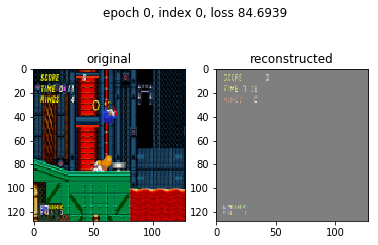

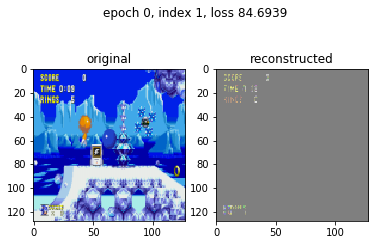

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


[15999/16000] loss=75.9302



[3999/4000] loss=76.1233

Epoch 0, loss=75.9302, loss_val=76.1233


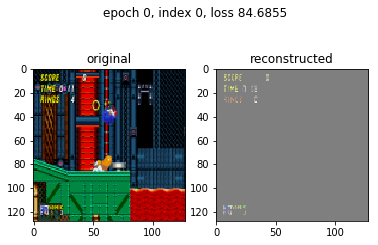

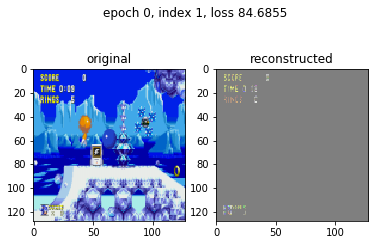

[15999/16000] loss=75.9287



[3999/4000] loss=76.1223

Epoch 1, loss=75.9287, loss_val=76.1223


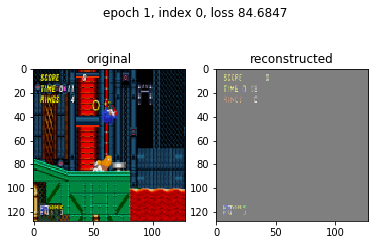

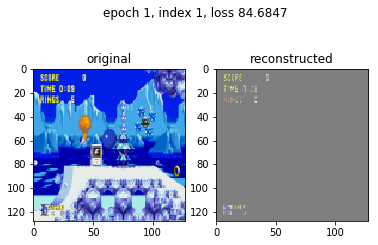

[15999/16000] loss=75.9281



[3999/4000] loss=76.1223

Epoch 2, loss=75.9281, loss_val=76.1223


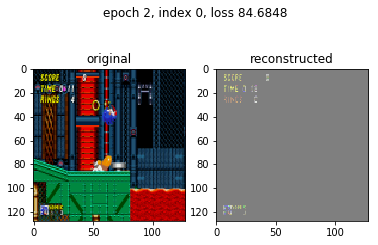

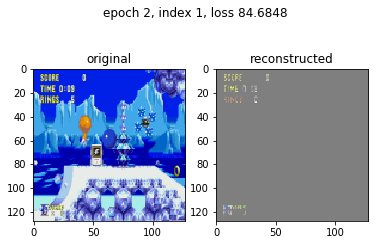

[15999/16000] loss=75.9279



[3999/4000] loss=76.1217

Epoch 3, loss=75.9279, loss_val=76.1217


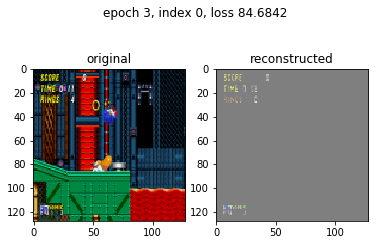

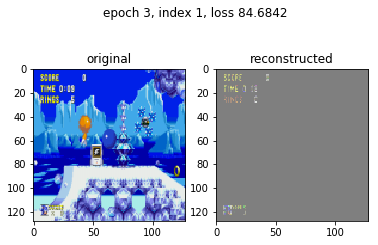

[15999/16000] loss=75.9274



[3999/4000] loss=76.1217

Epoch 4, loss=75.9274, loss_val=76.1217


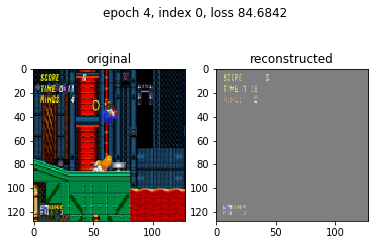

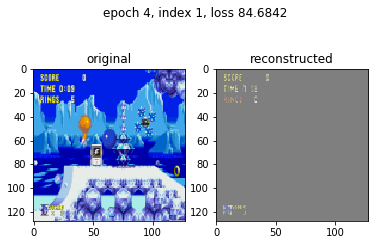

[15999/16000] loss=75.9274



[3999/4000] loss=76.1217

Epoch 5, loss=75.9274, loss_val=76.1217


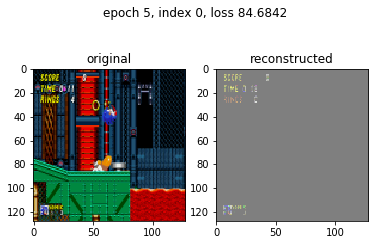

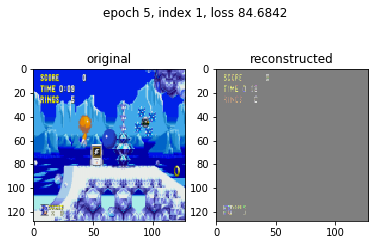

[15999/16000] loss=75.9274



[3999/4000] loss=76.1217

Epoch 6, loss=75.9274, loss_val=76.1217


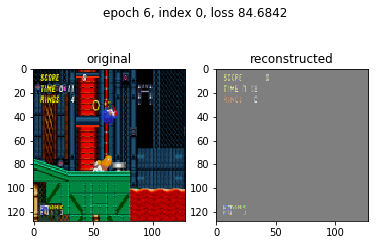

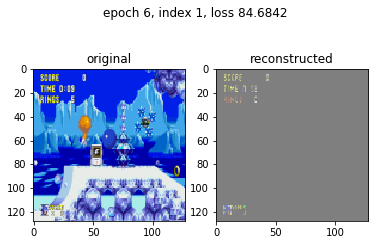

[15999/16000] loss=75.9274



[3999/4000] loss=76.1217

Epoch 7, loss=75.9274, loss_val=76.1217


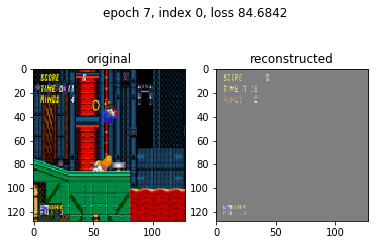

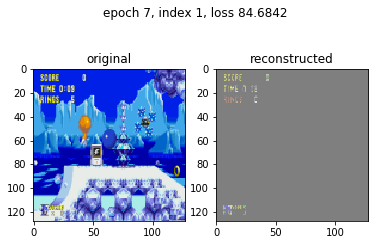

[15999/16000] loss=75.9274



[3999/4000] loss=76.1217

Epoch 8, loss=75.9274, loss_val=76.1217


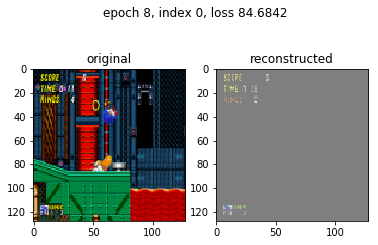

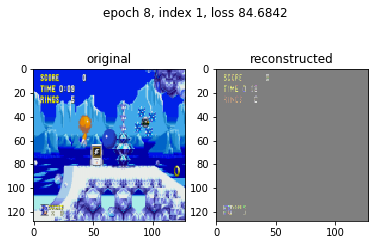

[15999/16000] loss=75.9274



[3999/4000] loss=76.1217

Epoch 9, loss=75.9274, loss_val=76.1217


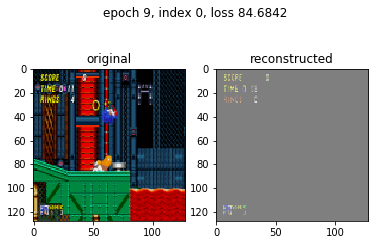

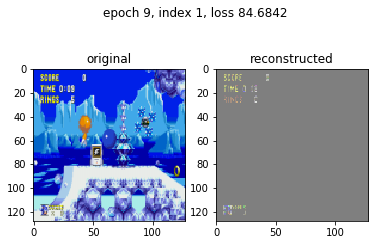

In [ ]:

for epoch in range(num_epochs): 
    info = train(loader_train, vae, optimizer, loss_function, test=False, cuda=True)
    info_val = train(loader_test, vae, optimizer, loss_function, test=True, cuda=True)
    scheduler.step(np.mean(info_val['loss']))
    
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}'.format(epoch, np.mean(info['loss']), np.mean(info_val['loss'])))
    infos.append([info, info_val])
    
    plot_results(loader=loader_test, n=2, epoch=epoch)
    
    torch.save(vae.state_dict(), './models/VAE_{}_state_dict_2y.pkl'.format(epoch))

If it improved over 75 keeps it, else try lr=1e-5, else try smaller, then larger batches.

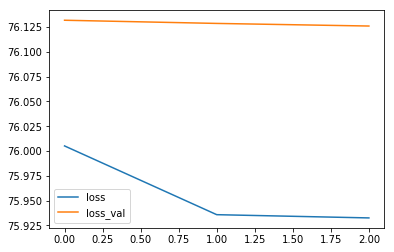

In [35]:
# plot history
import pandas as pd
histories = []
for info, info_val in infos:
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
histories = pd.DataFrame(histories)
histories.plot()

In [ ]:
torch.save(vae.state_dict(), './models/VAE_state_dict_2y.pkl')
torch.save(vae, './models/VAE_2y.pkl')

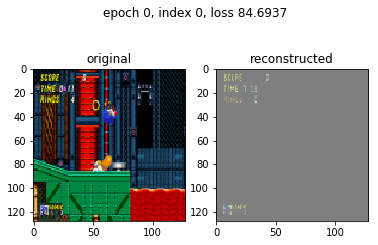

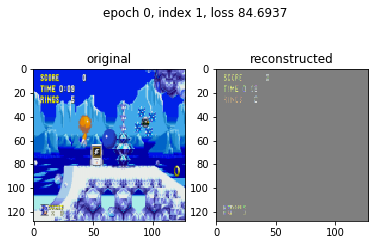

In [34]:
plot_results(loader=loader_test, n=2, epoch=0)

# End